In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import os

In [2]:
import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
store_ele = pd.HDFStore("output_PU_clusters_check_ele_v6.h5")
store_ele2 = pd.HDFStore("output_PU_clusters_check_ele_v6.2.h5")
dfele = pd.concat([store_ele['df'], store_ele2['df']])
df =dfele
store_ele.close()
store_ele2.close()
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/simfraction_electron"
os.makedirs(outputdir, exist_ok=True)

In [4]:
store_gam = pd.HDFStore("output_PU_clusters_check_gamma_v6.h5")
store_gam2 = pd.HDFStore("output_PU_clusters_check_gamma_v6.2.h5")
dfgamma = pd.concat([store_gam['df'], store_gam2['df']])
df = dfgamma
store_gam.close()
store_gam2.close()
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/simfraction_gamma"
os.makedirs(outputdir, exist_ok=True)

# Resolution study

Let's study the best threshold for resolution

In [4]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [5]:
seed = df[(df.is_seed==1)][['wi','en','eta','et', 'simfrac_sig']]
seed.columns = ['wi','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("wi"), on='wi')

In [6]:
np.logspace(-4,-0.7, 40)

array([1.00000000e-04, 1.21510941e-04, 1.47649088e-04, 1.79409797e-04,
       2.18002532e-04, 2.64896929e-04, 3.21878751e-04, 3.91117900e-04,
       4.75251041e-04, 5.77482013e-04, 7.01703829e-04, 8.52646926e-04,
       1.03605930e-03, 1.25892541e-03, 1.52973212e-03, 1.85879189e-03,
       2.25863552e-03, 2.74448928e-03, 3.33485475e-03, 4.05221339e-03,
       4.92388263e-03, 5.98305613e-03, 7.27006781e-03, 8.83392781e-03,
       1.07341888e-02, 1.30432139e-02, 1.58489319e-02, 1.92581863e-02,
       2.34008035e-02, 2.84345365e-02, 3.45510729e-02, 4.19833339e-02,
       5.10143442e-02, 6.19880097e-02, 7.53222140e-02, 9.15247311e-02,
       1.11212562e-01, 1.35135431e-01, 1.64204334e-01, 1.99526231e-01])

In [7]:
# etas = [0,0.4,0.6,0.8,1.2,1.44, 1.57, 1.65, 1.75,2,2.25,2.5, 3]
etas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.35, 1.44, 1.57, 1.75, 2.0 ,2.2,2.4,3.0]
# ets =  [0,2,4,6,8,10,20,30,40,50,60,80,100]
ets = [ 0,2,3,4,6,10,15,20,30,40,50,60,70,80,90,100]
# thres = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08 ,0.09 ,0.1 ,
#          0.15 ,0.20 ,0.25 ,0.30 ,0.40 ,0.50, 0.60 ,0.70, 0.80]
thres = np.logspace(-4,-0.7, 40)
    
res= []
# res_all = []

dfb = dfa[(dfa.seed_simfrac_sig > 0.01) & (dfa.in_window)]

for thr in thres:
    #print("DNN threshold: ", thr)
    g = dfb[(dfb.simfrac_sig >  thr) | (dfb.is_seed==1) ].groupby("wi", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_simen_good": "first", 
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen_good"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"], etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)                   
    scanres["thr"] = thr
    res.append(scanres)



res = pd.concat(res)


In [8]:
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

In [9]:
res

eta_bin et_bin  quantile_down  quantile_up  EoEtrue_68scale  \
0          0      0       0.417096     0.843478         0.649403   
1          1      0       0.448019     0.834940         0.646421   
2          2      0       0.422937     0.844661         0.651632   
3          3      0       0.458019     0.865020         0.675005   
4          4      0       0.462858     0.848653         0.664559   
...      ...    ...            ...          ...              ...   
8395       9     14       0.980643     1.020491         1.001144   
8396      10     14       0.991315     1.023070         1.007275   
8397      11     14       0.995211     1.030031         1.012288   
8398      12     14       0.995077     1.036009         1.015255   
8399      13     14       0.984668     1.059430         1.020852   

      EoEtrue_68width  EoEtrue_scale  EoEtrue_rms   rel_err       thr  
0            0.213191       0.719481     1.744947  0.024492  0.000100  
1            0.193460       0.662721     0.257430  0.025016  0.000100  
2            0.210862       0.667642     0.295885  0.024347  0.000100  
3            0.203501       0.706416     0.652436  0.025063  0.000100  
4            0.192897       0.698325     0.831785  0.021082  0.000100  
...               ...            ...          ...       ...       ...  
8395         0.019924       1.013997     0.120951  0.030110  0.199526  
8396         0.015878       1.007415     0.018373  0.023250  0.199526  
8397         0.017410       1.012437     0.018209  0.019642  0.199526  
8398         0.020466       1.016095     0.021449  0.018722  0.199526  
8399         0.037381       1.022630     0.039202  0.012339  0.199526  

[8400 rows x 10 columns]

## By Et and eta bin

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


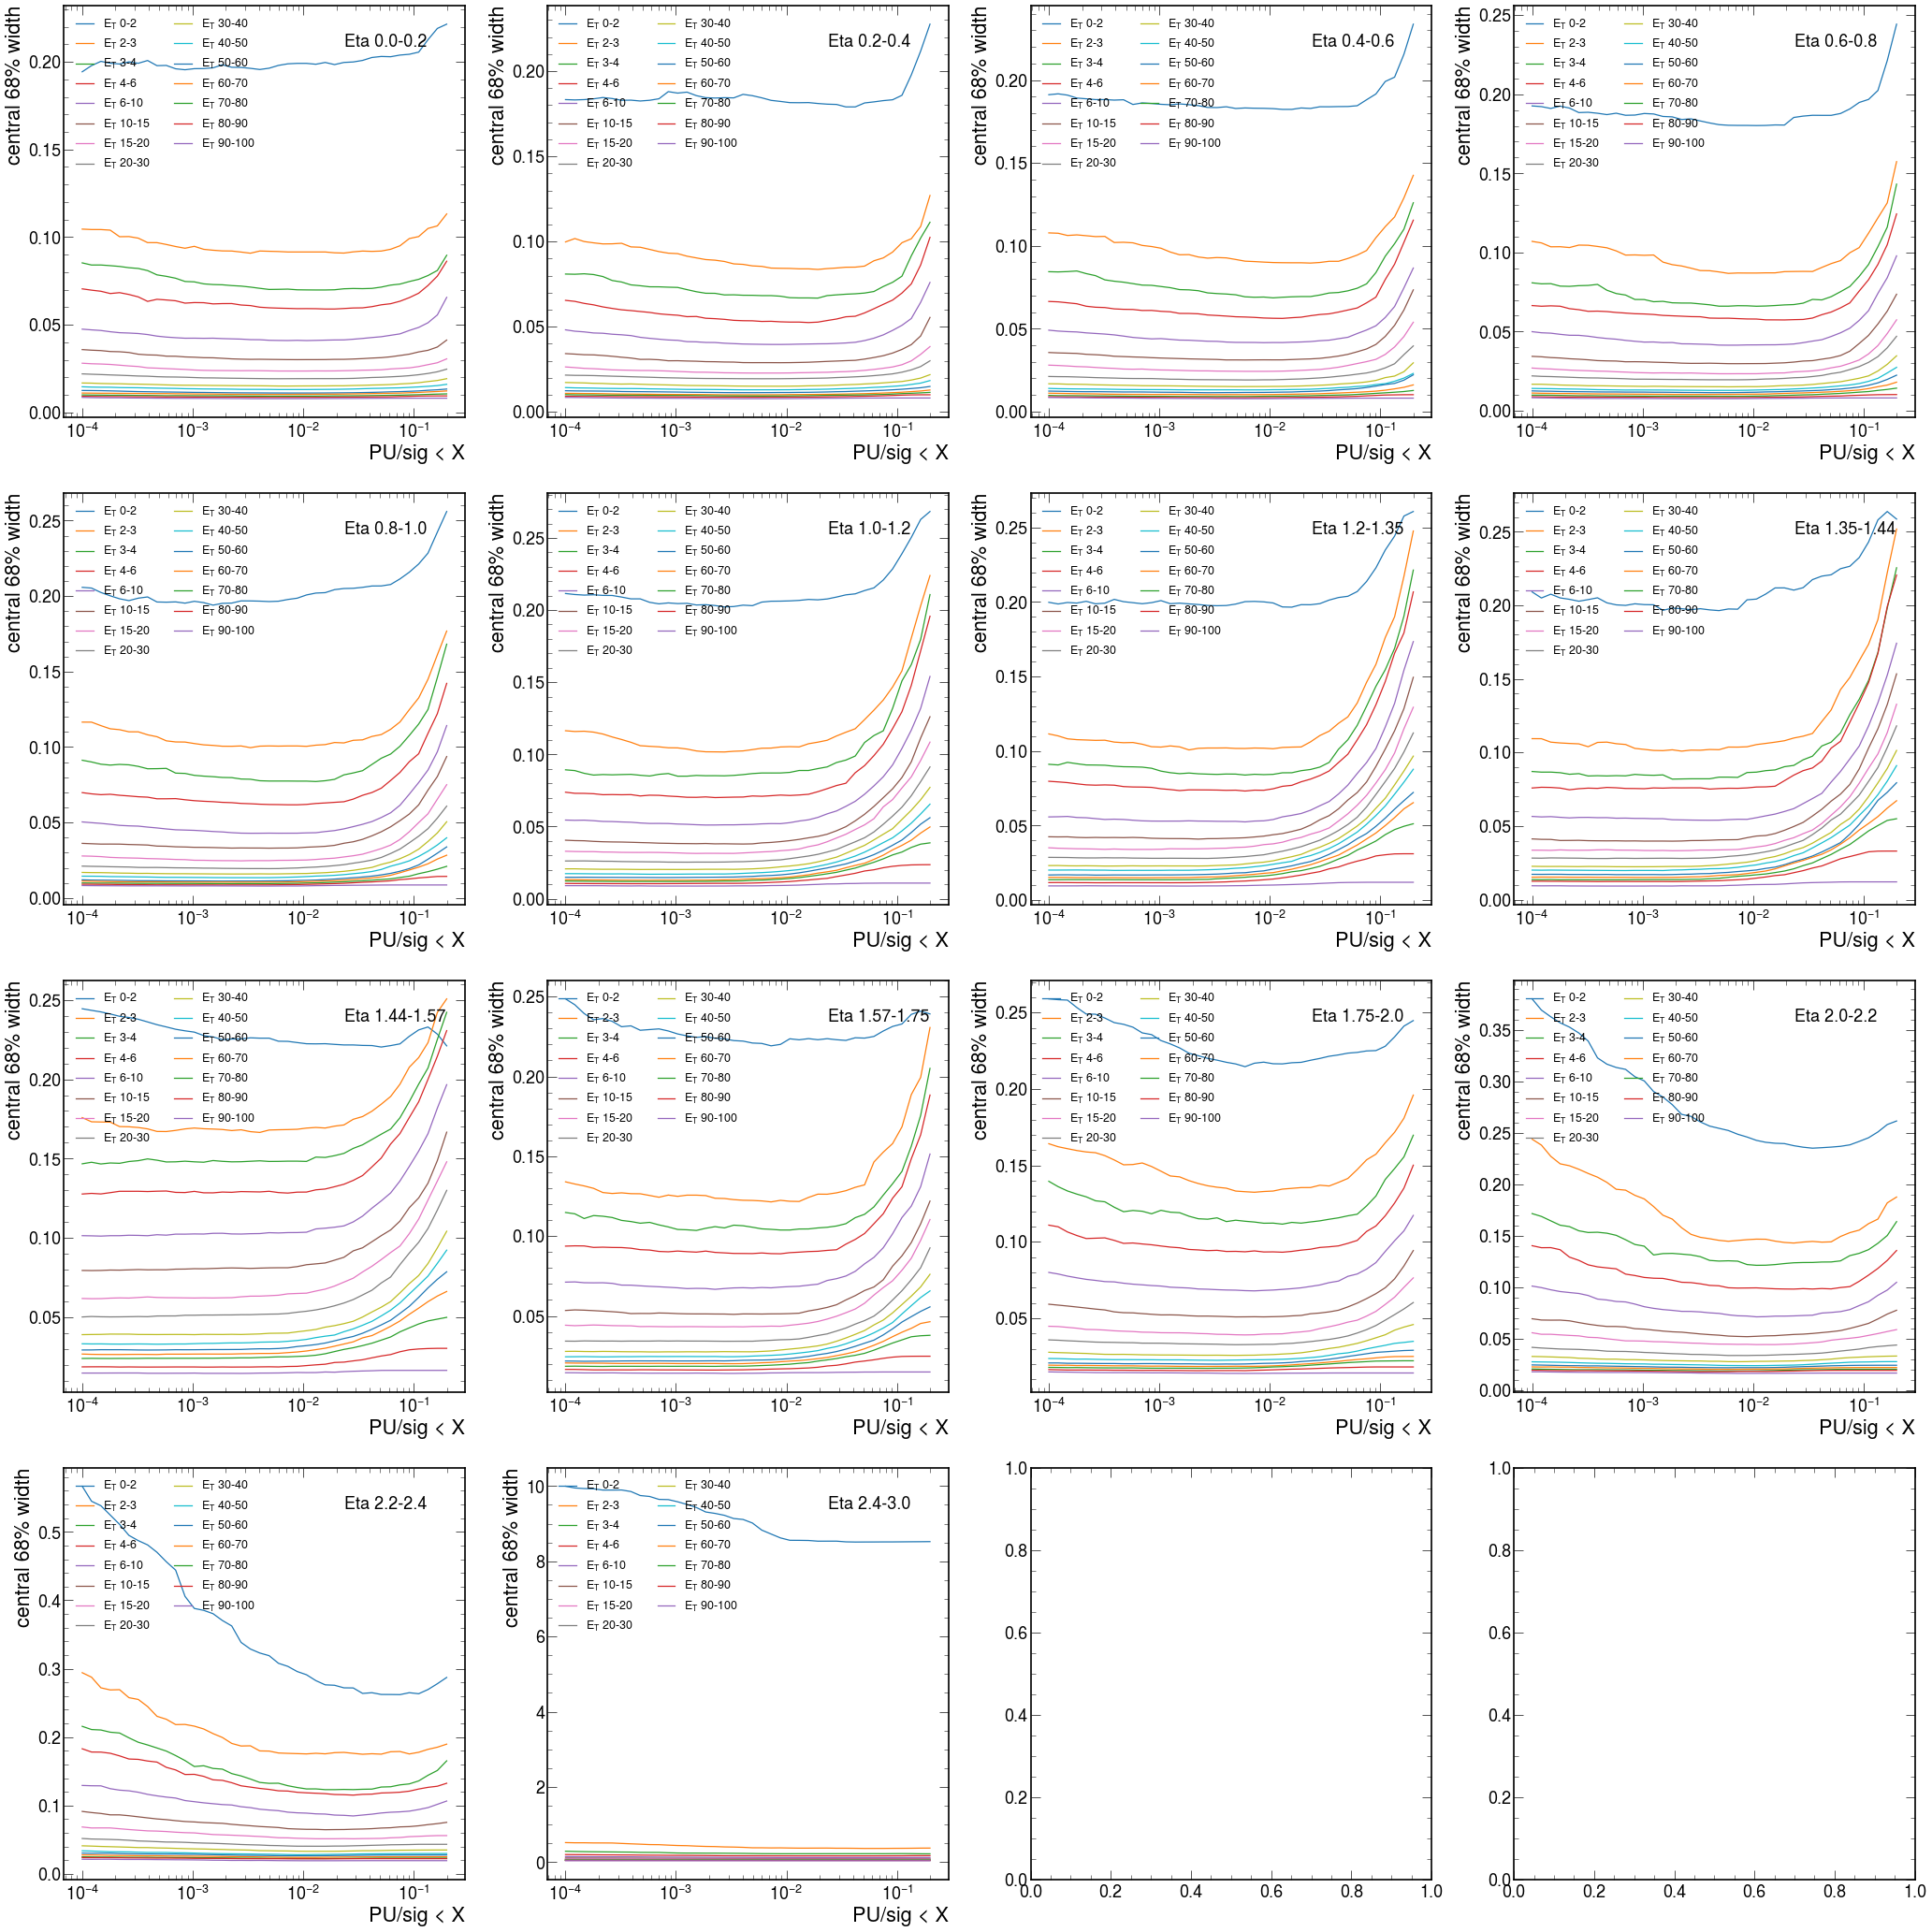

In [10]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.7,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("PU/sig < X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Width_all.png')

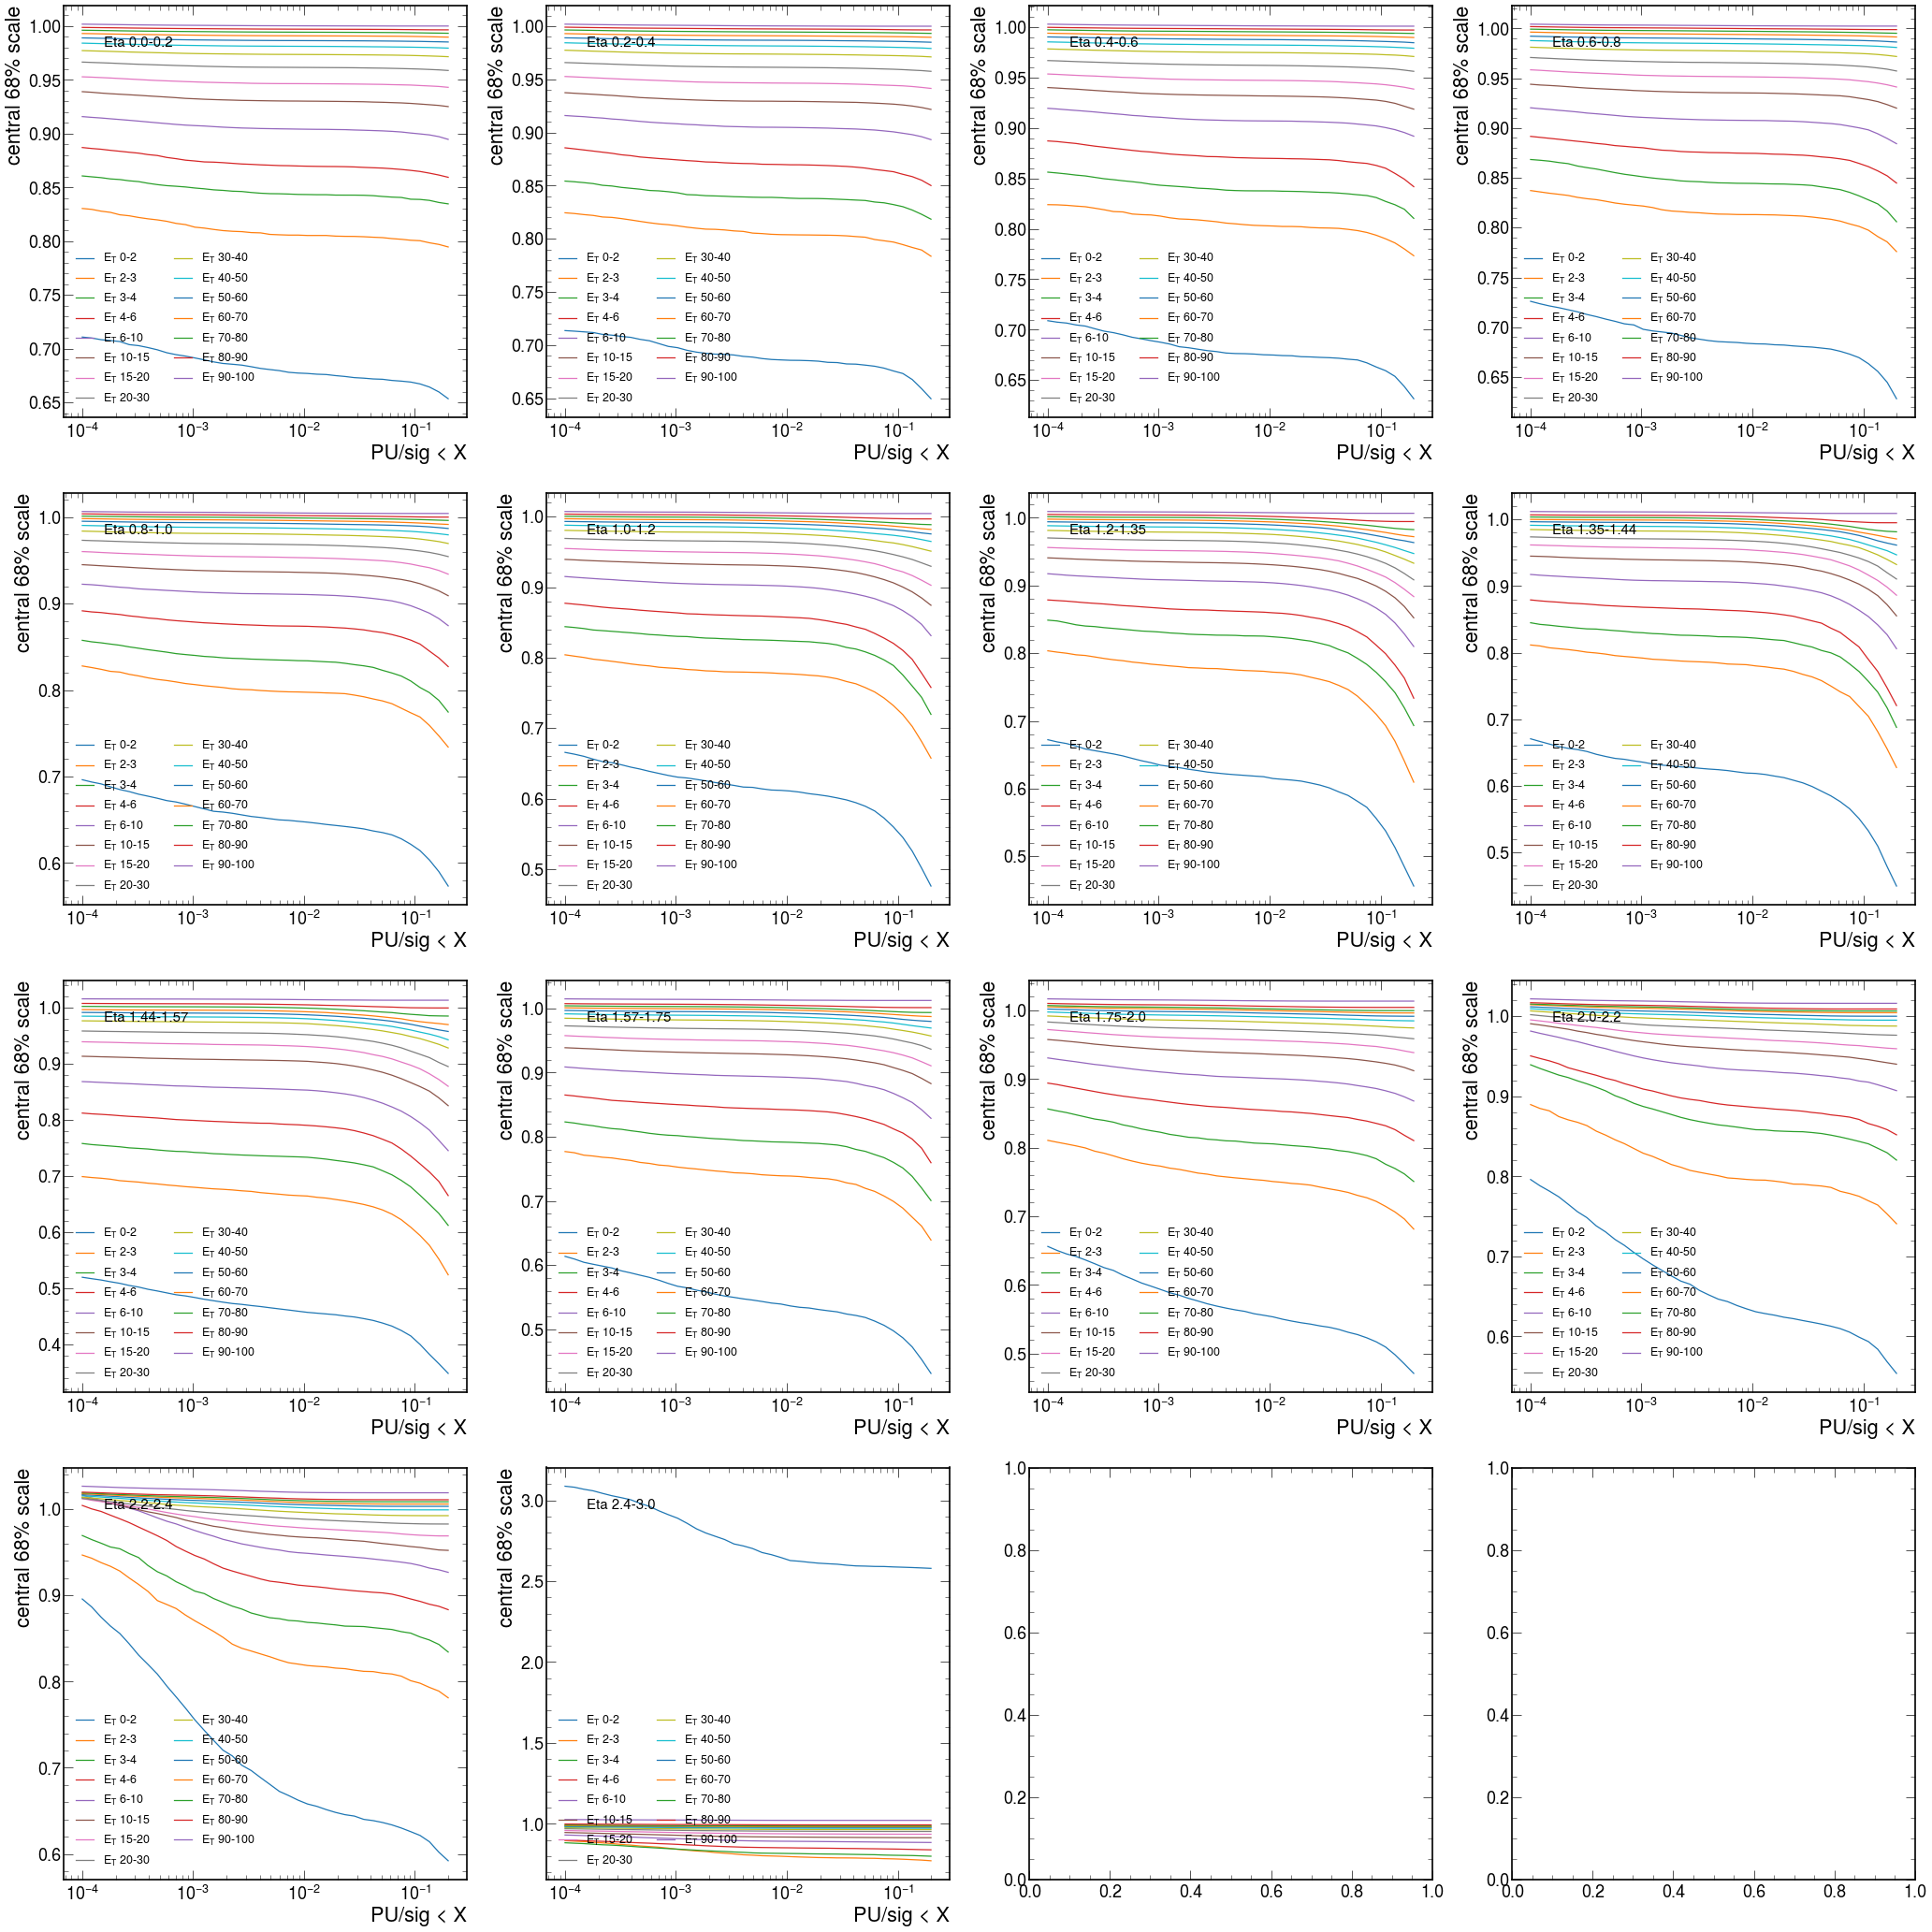

In [11]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% scale")
    ax.set_xlabel("PU/sig < X")
#     ax.set_xlim(0.001, 0.05)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Scale_all.png')

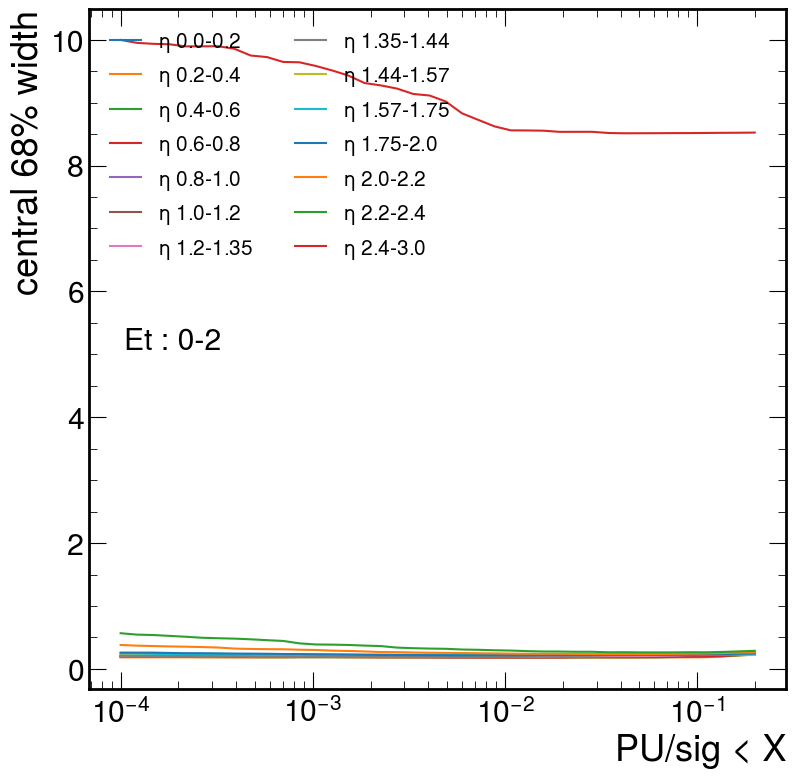

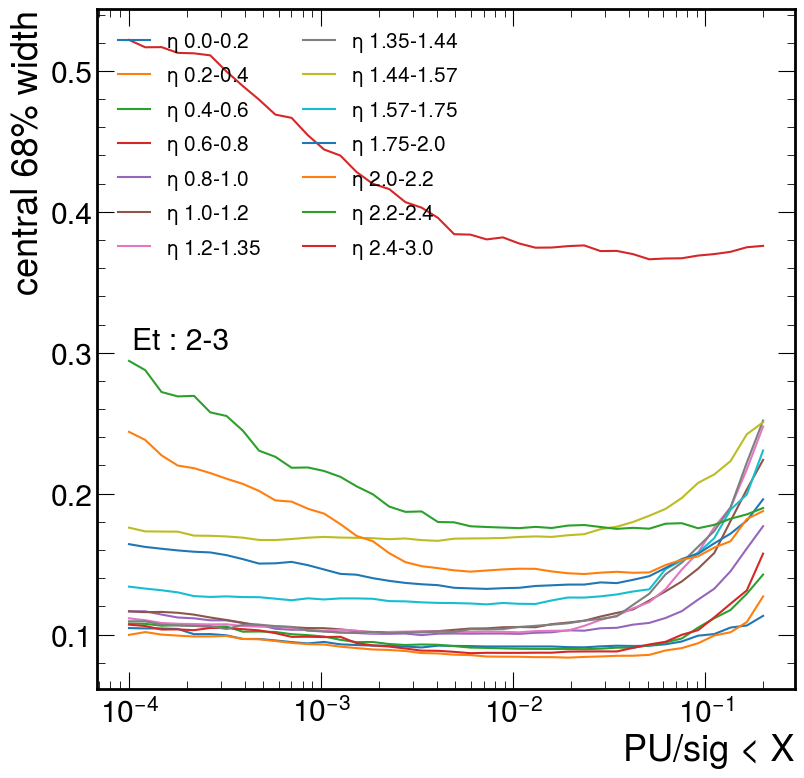

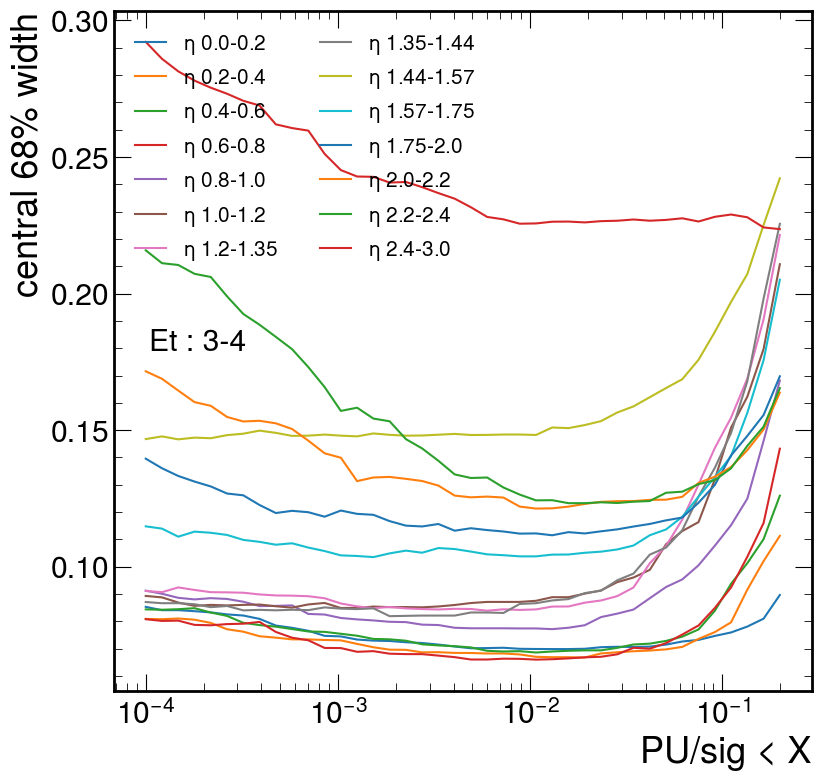

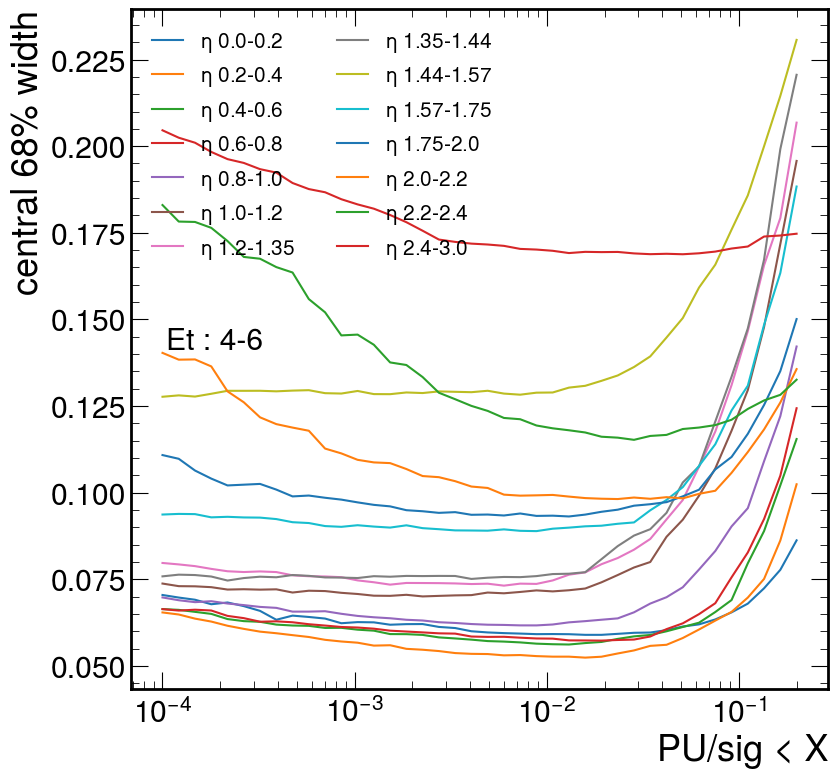

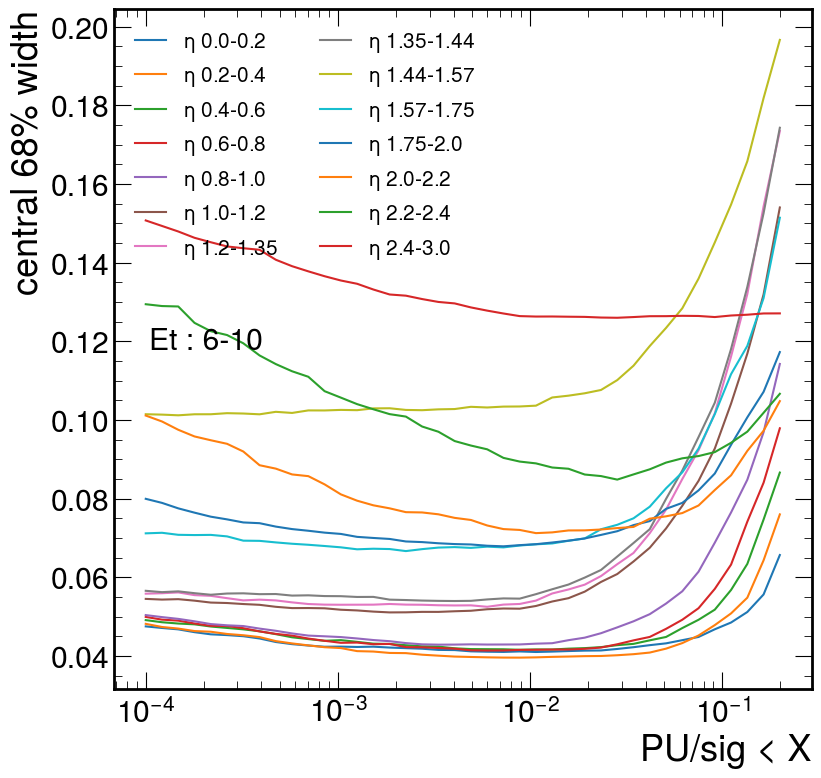

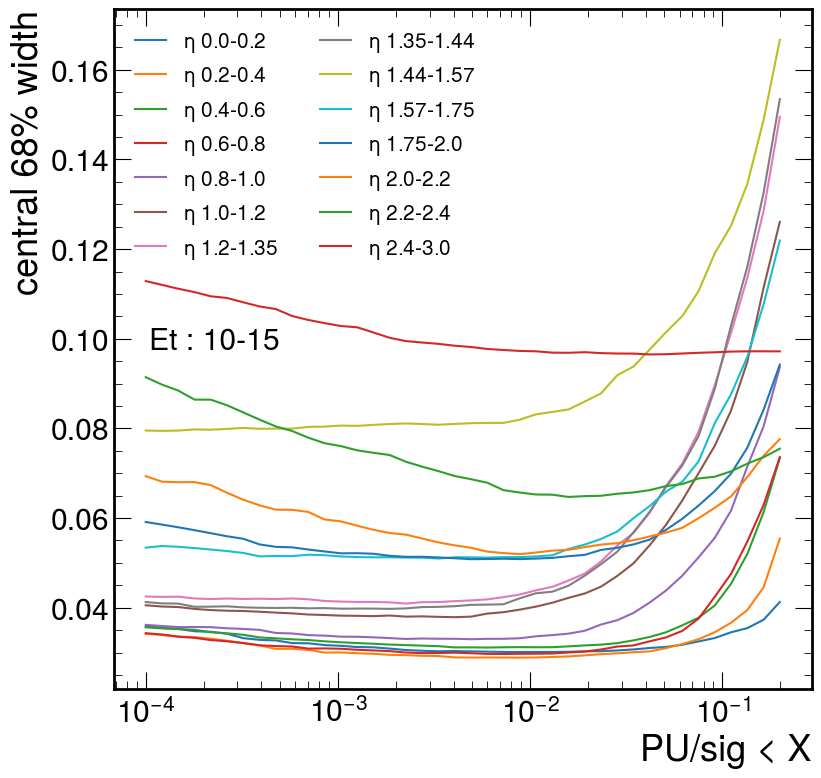

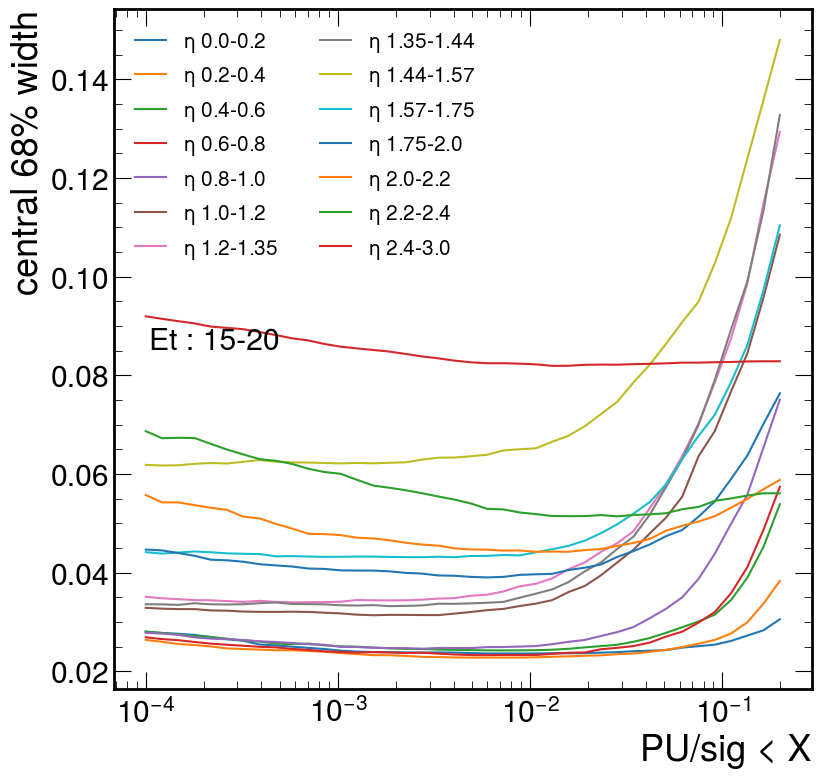

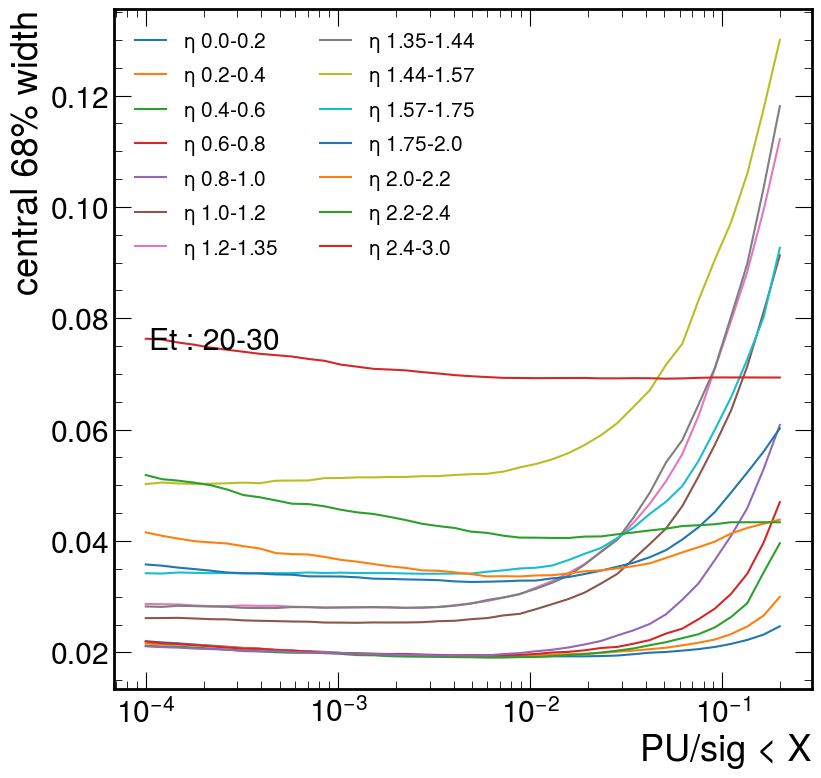

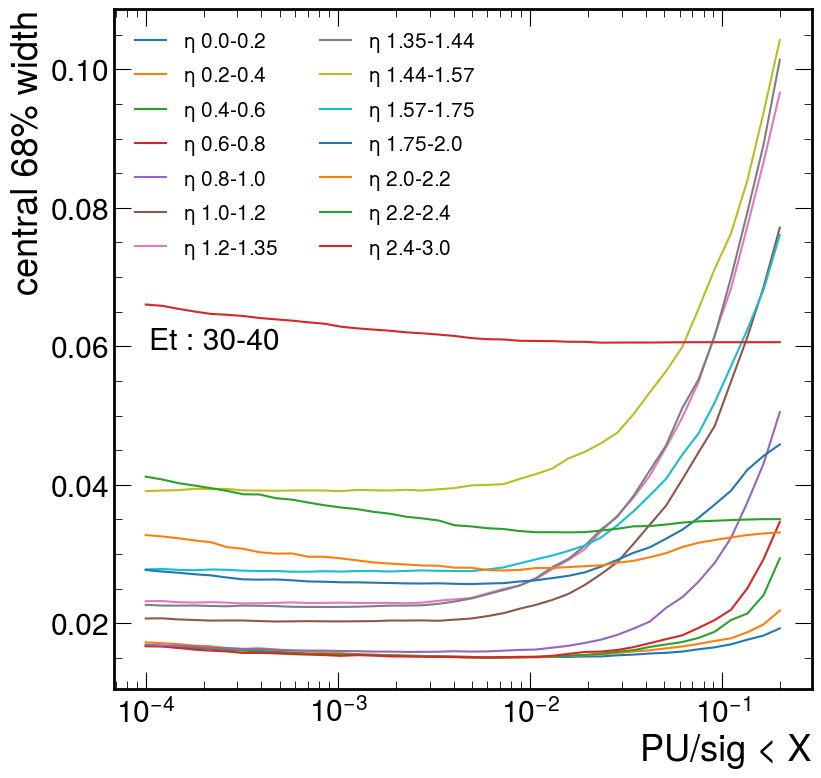

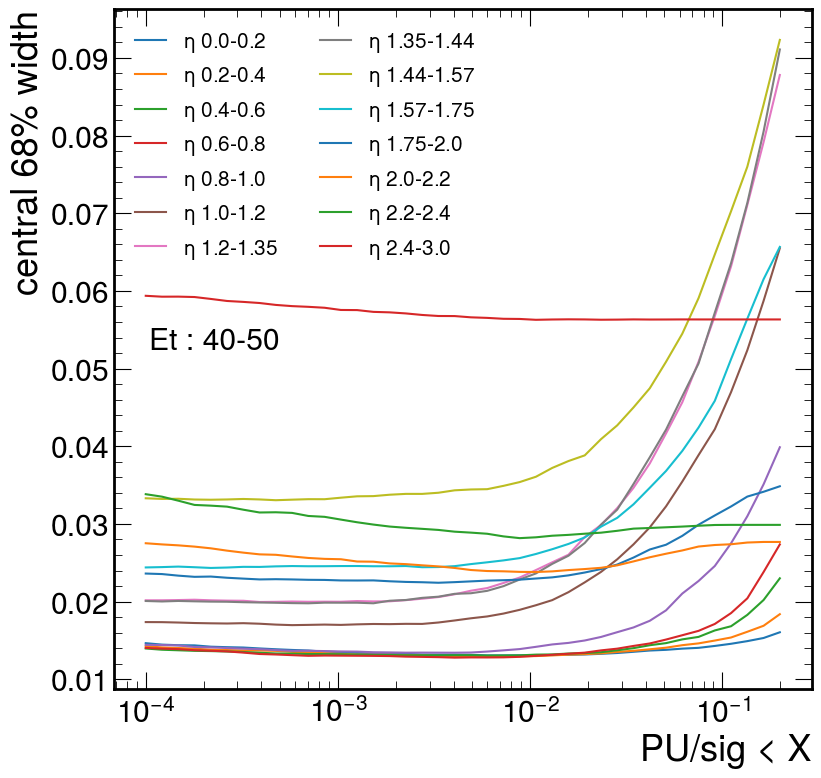

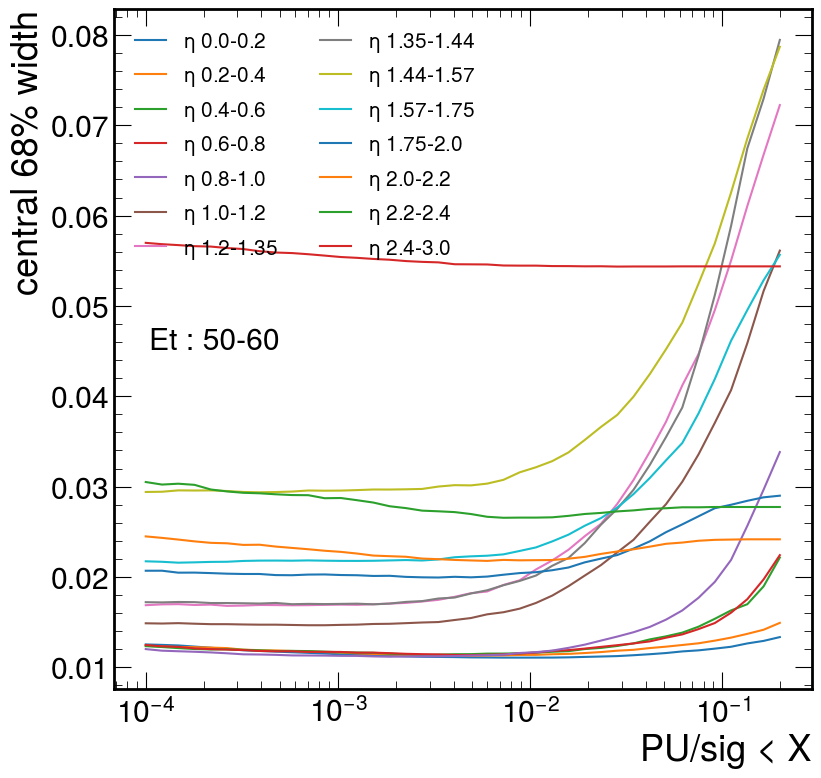

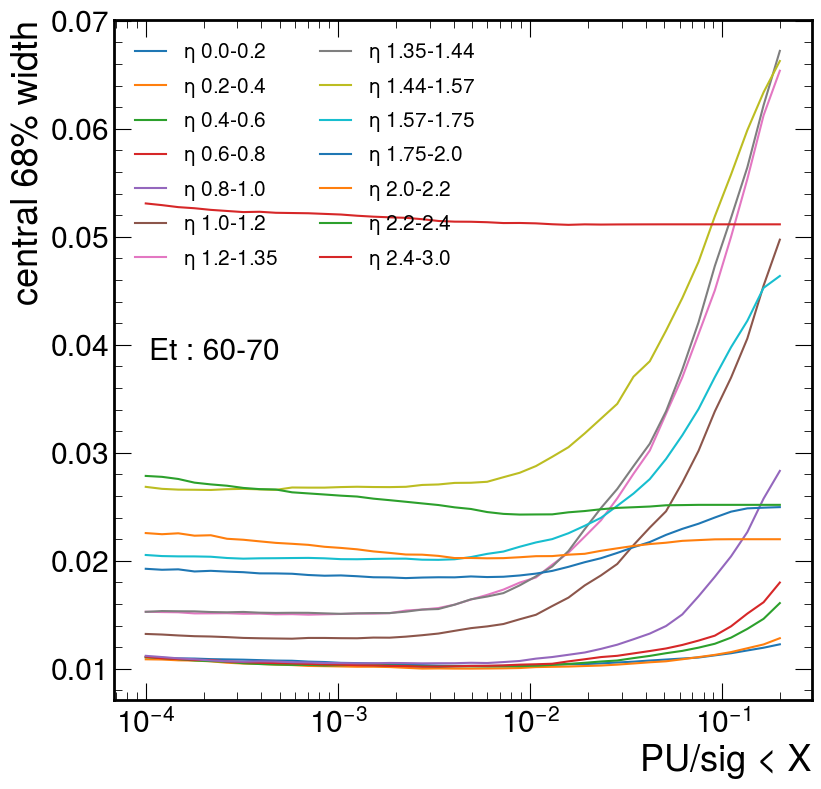

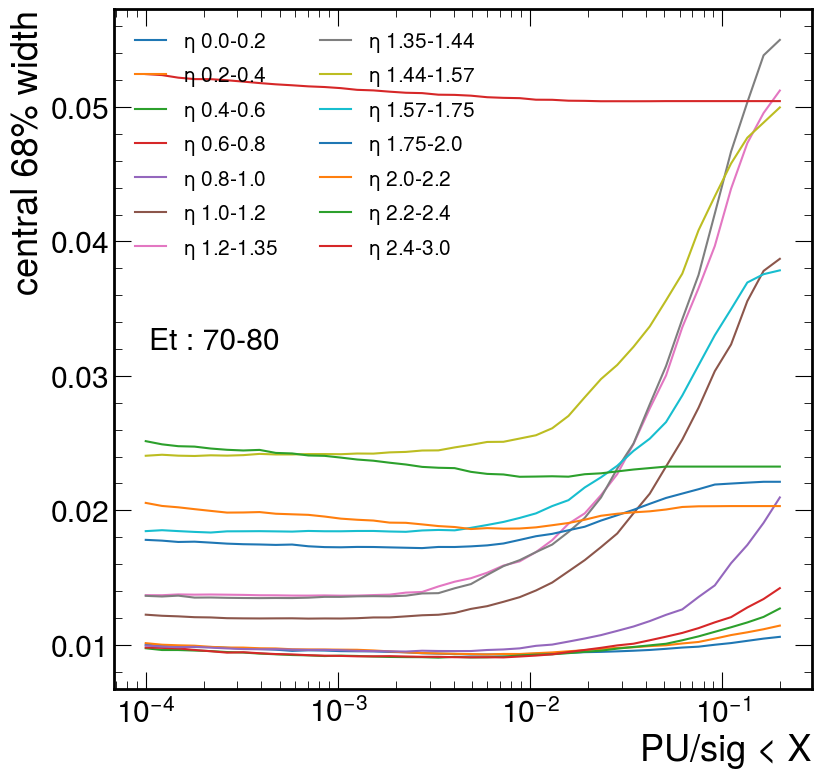

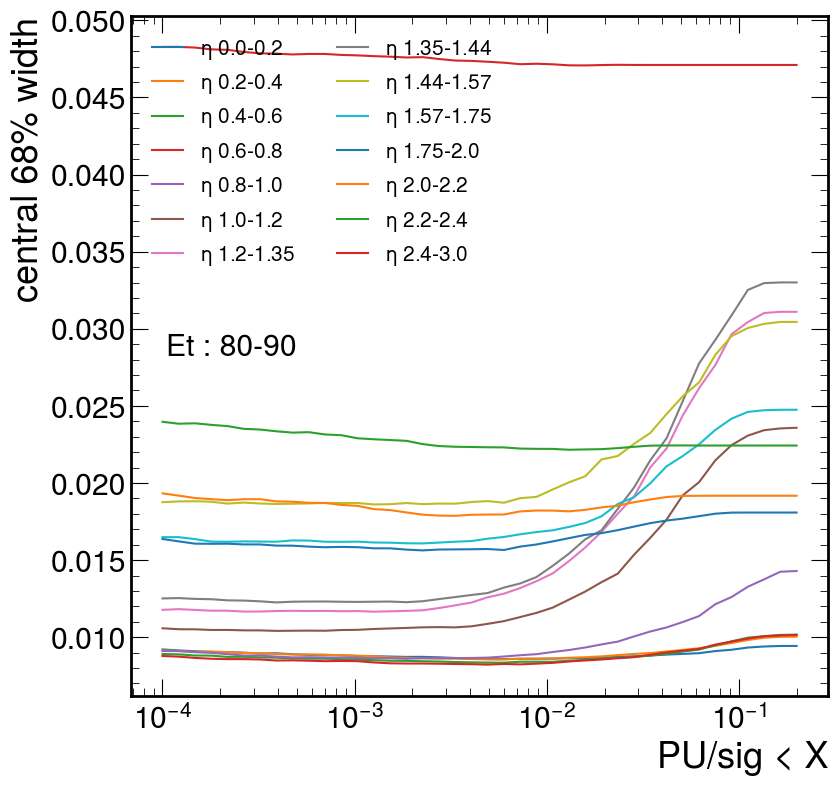

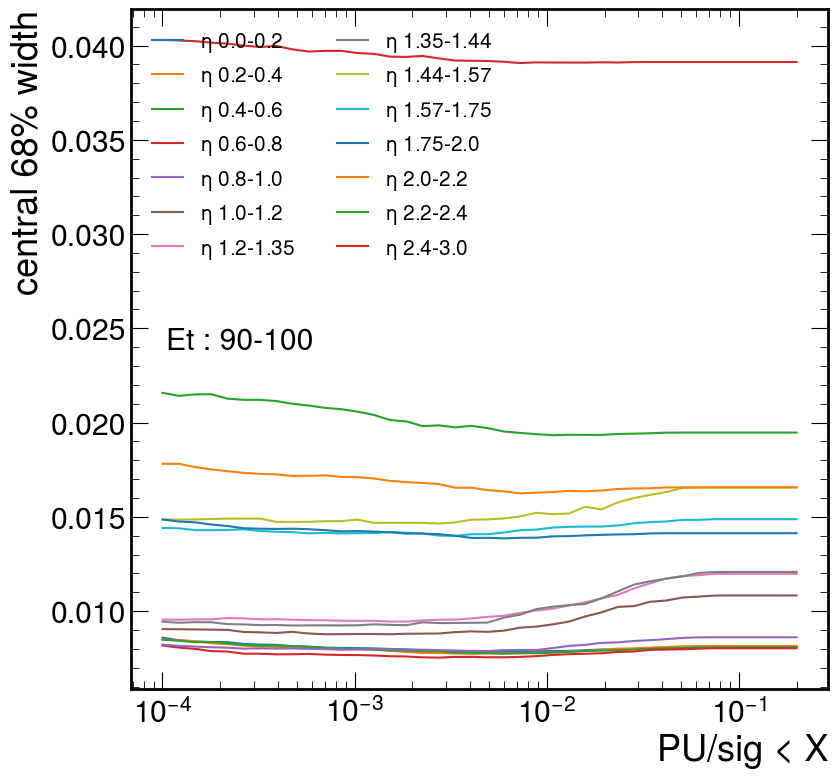

In [12]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("PU/sig < X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_Et{}_{}.png'.format(ets[iet],ets[iet+1]))

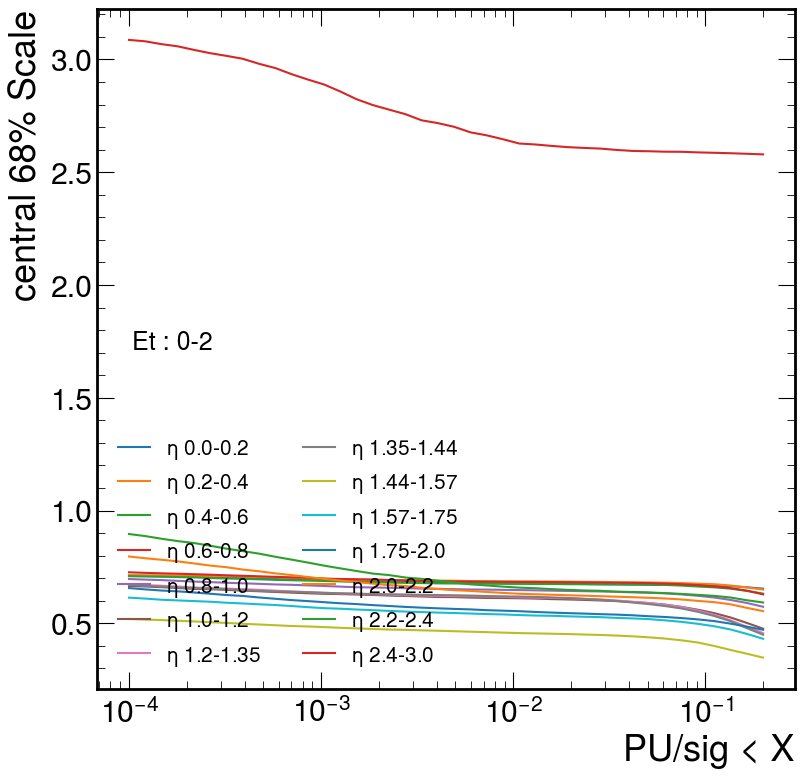

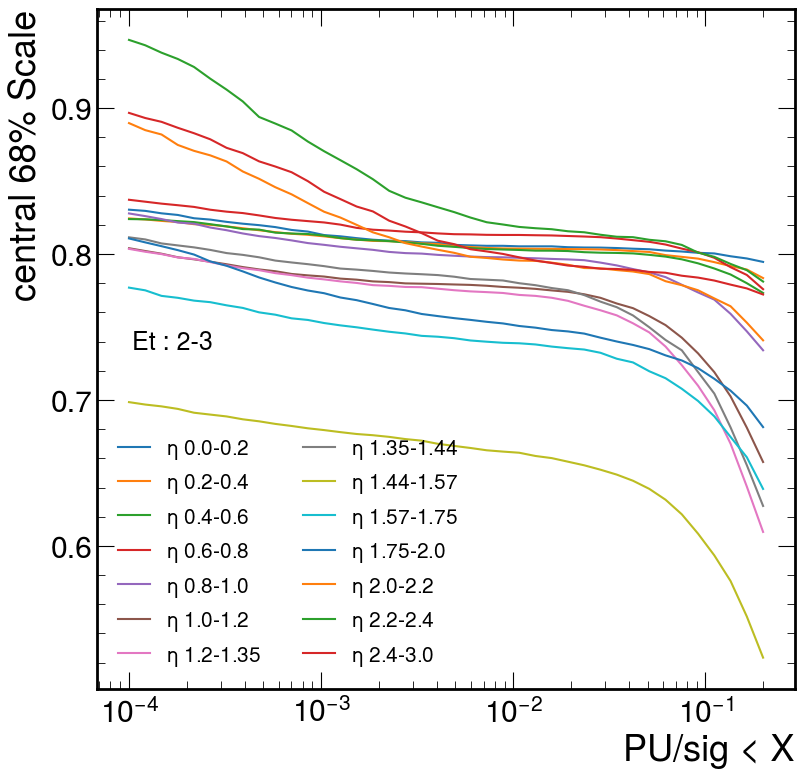

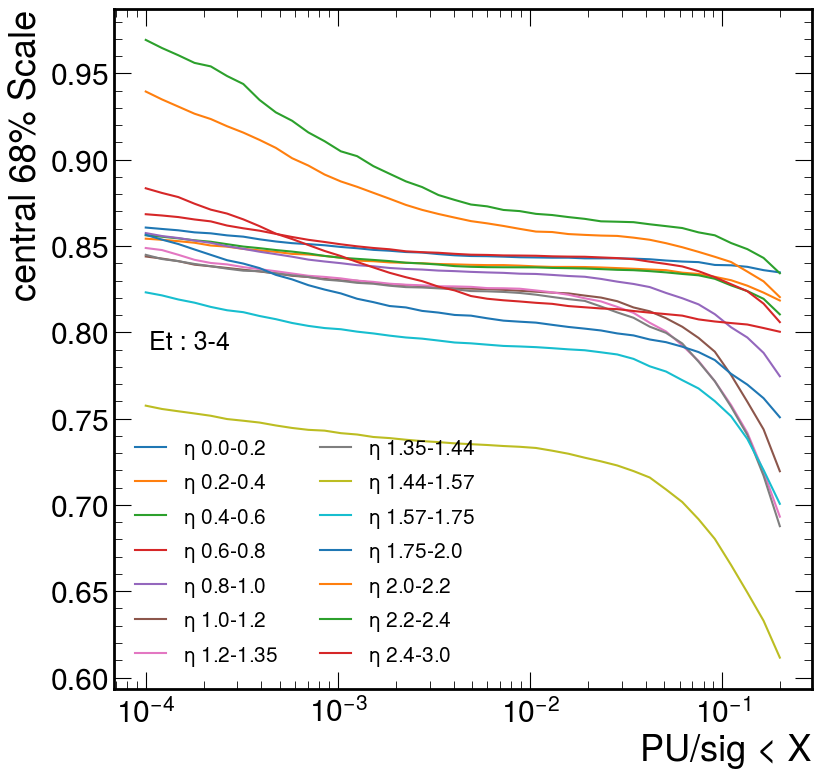

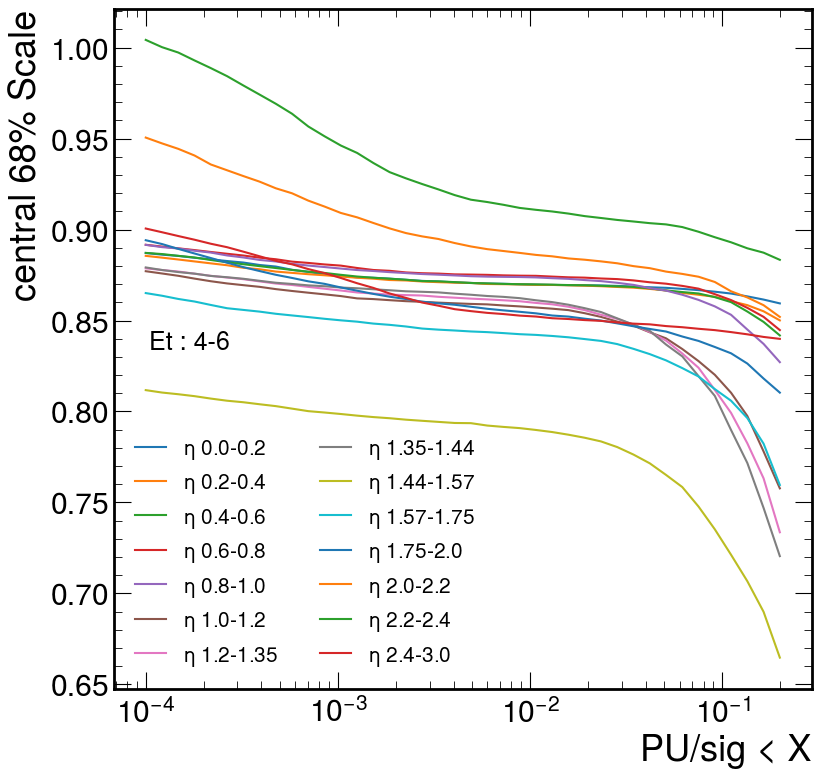

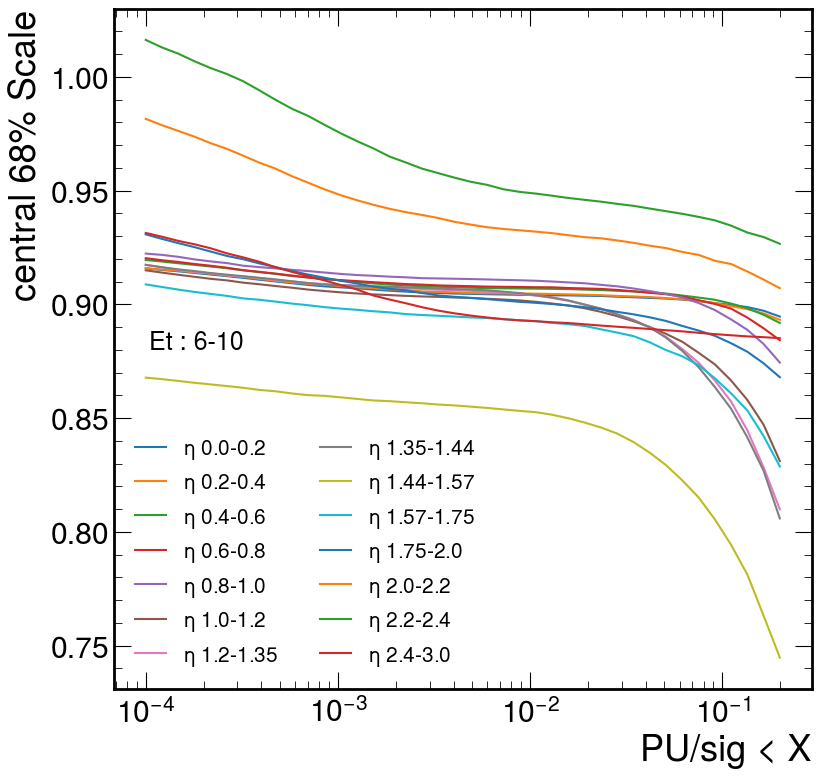

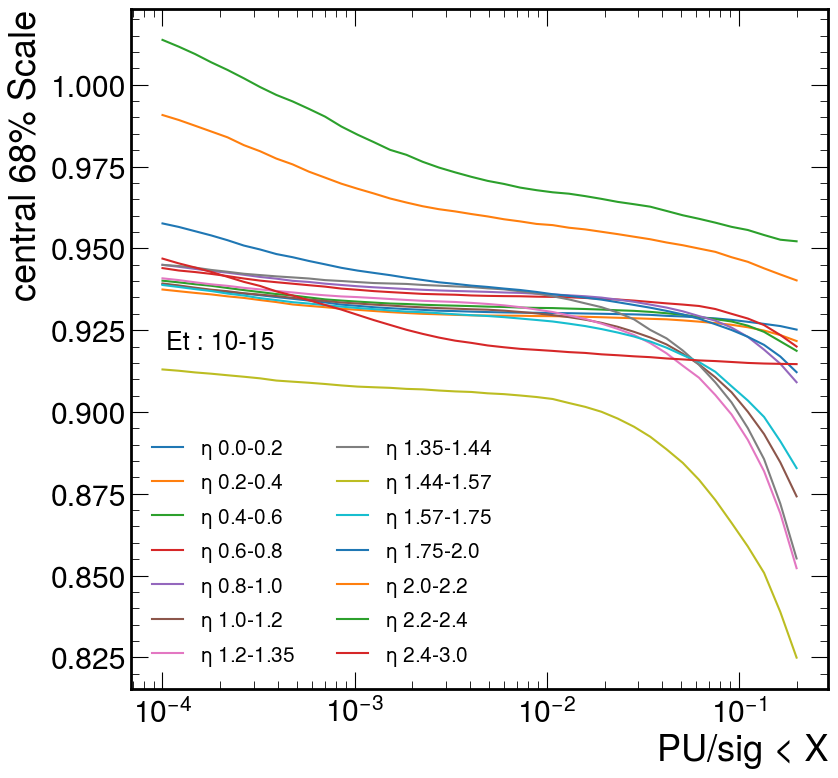

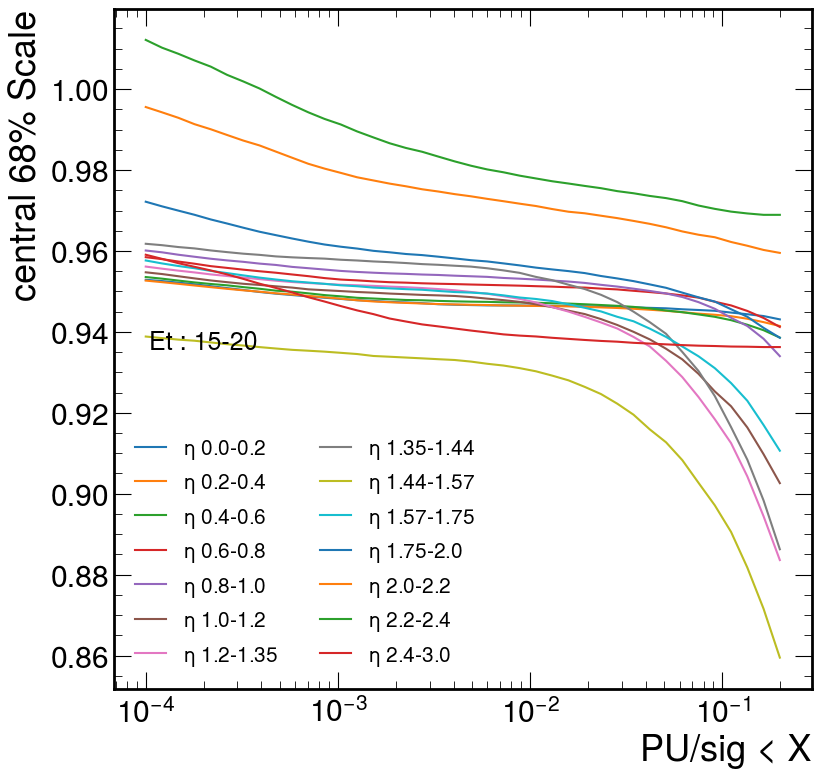

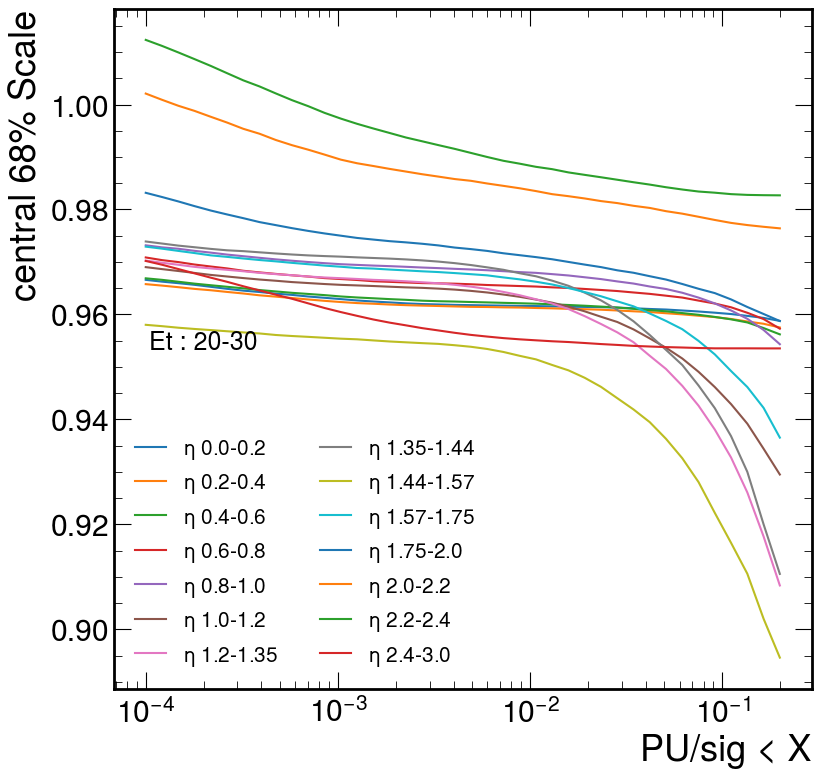

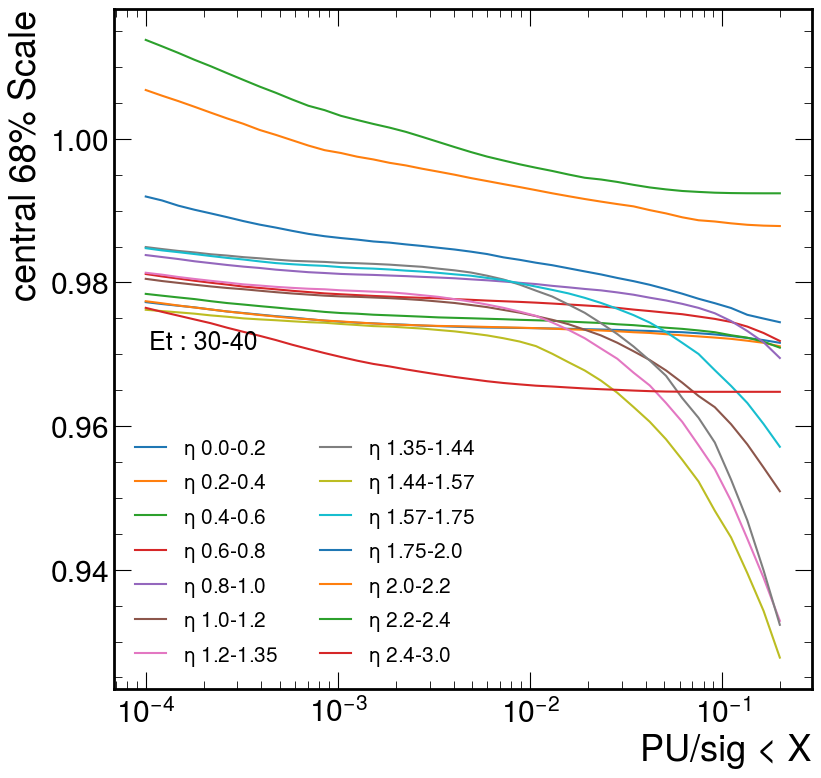

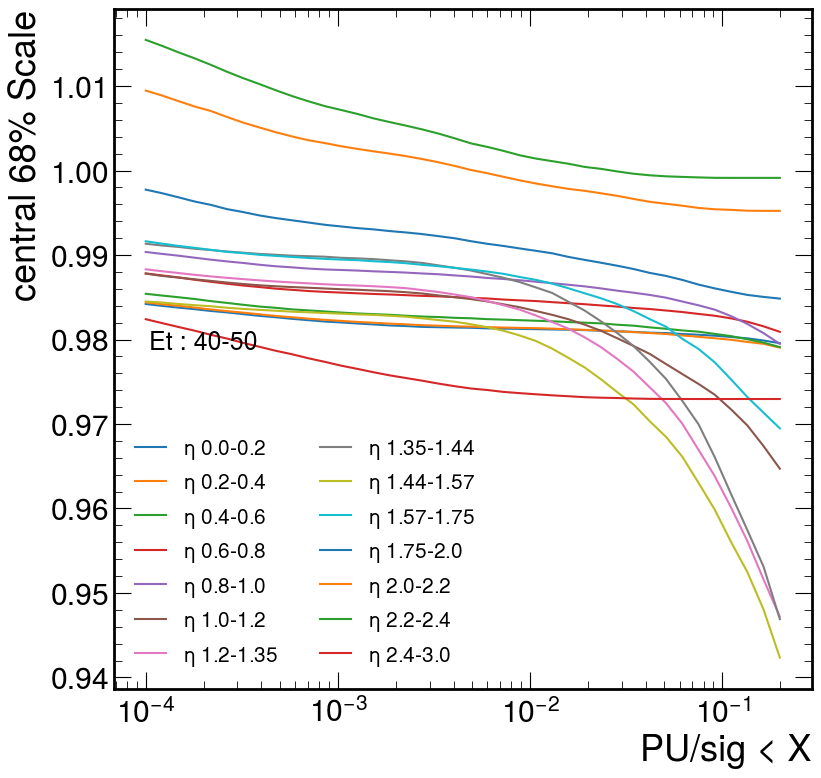

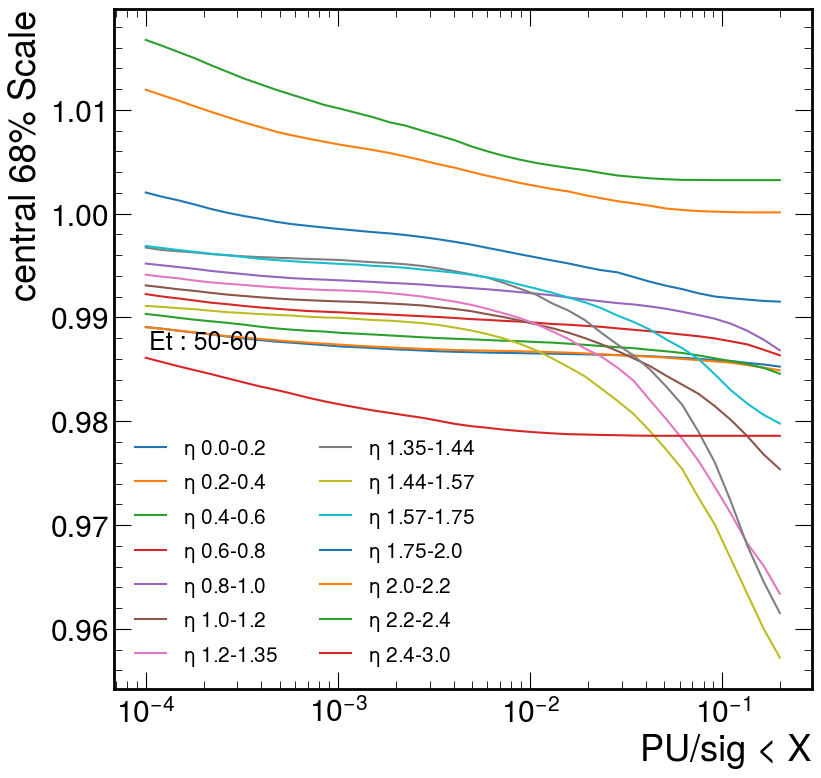

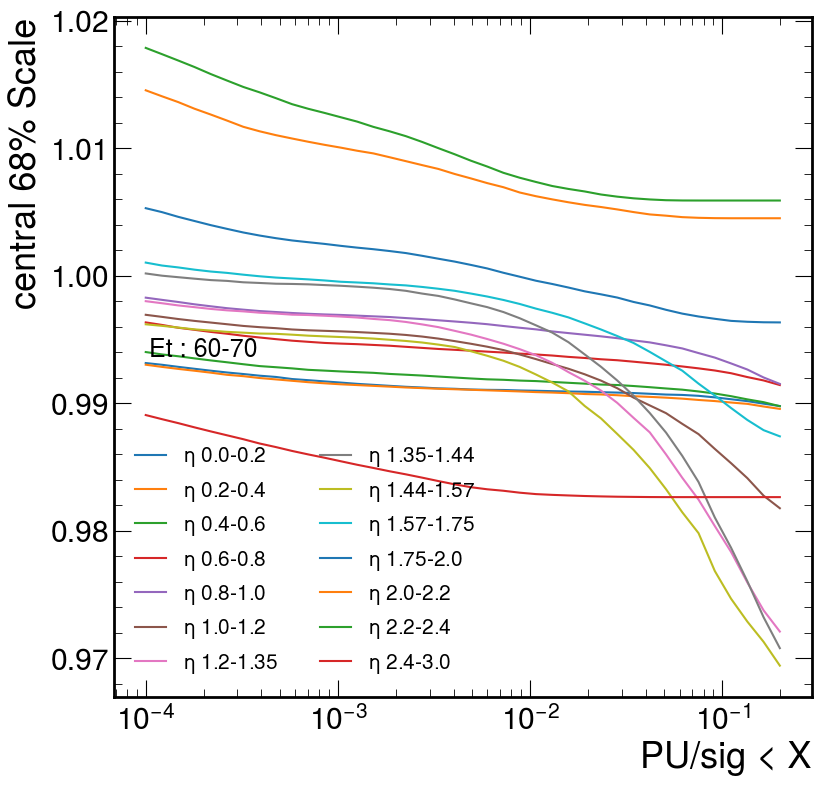

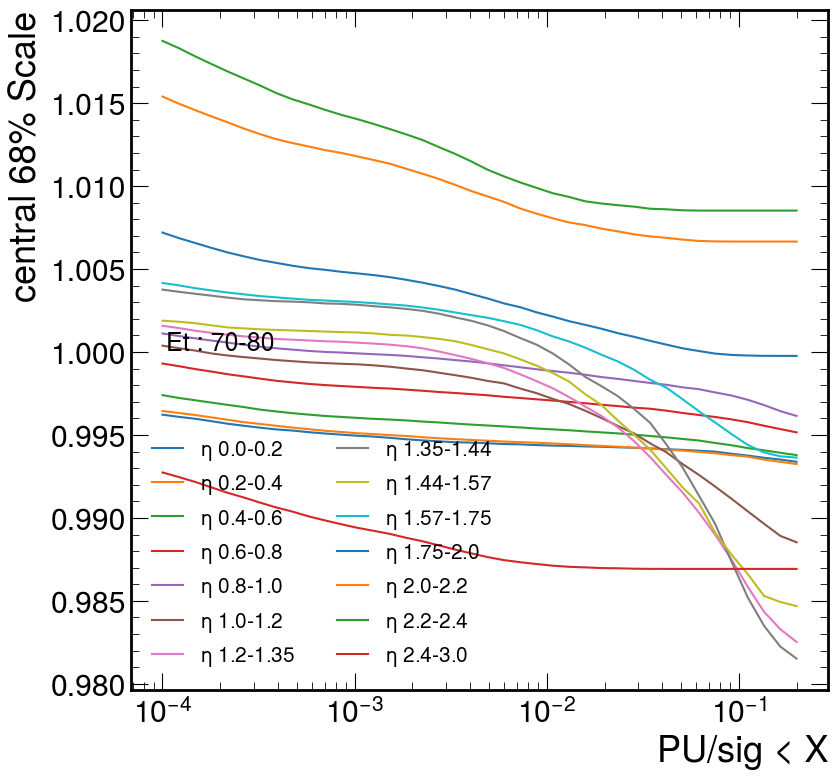

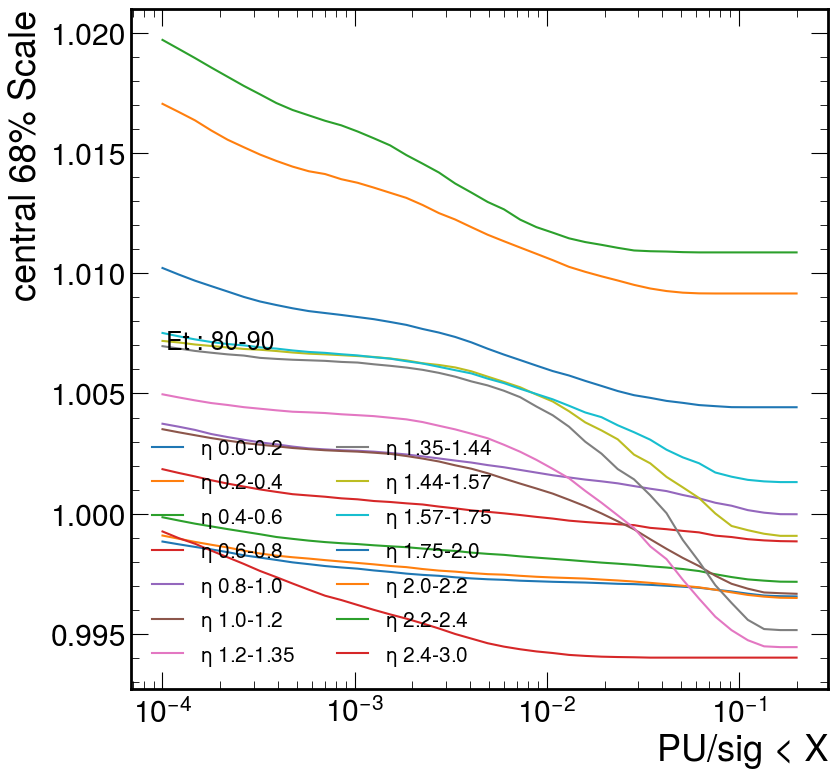

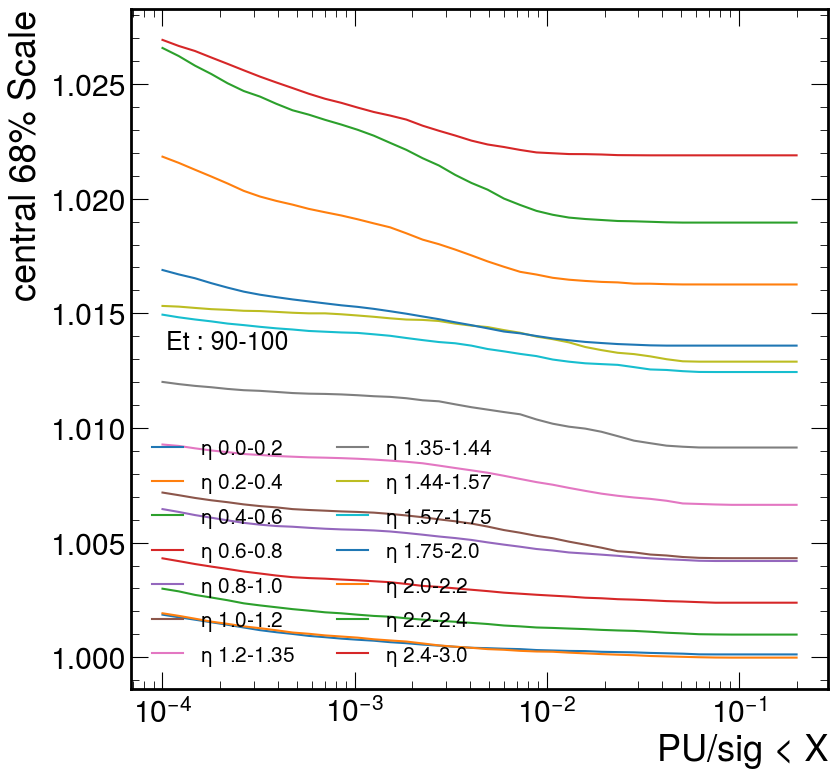

In [13]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% Scale")
    ax.set_xlabel("PU/sig < X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Scale_{}_{}.png'.format(ets[iet],ets[iet+1]))

# Summary

In [10]:
def bin_analysis_summary(df):
    line = df.iloc[df["EoEtrue_68width"].argmin()]
    return pd.Series({
        "thr": line['thr'],
        "scale": line["EoEtrue_68width"],
        "width": line["EoEtrue_68width"],
        "rel_err" : line["rel_err"]
    })

a = res.groupby(['et_bin','eta_bin']).apply(bin_analysis_summary)

In [11]:
a.reset_index(level=0, inplace=True)
a.reset_index(level=0, inplace=True)

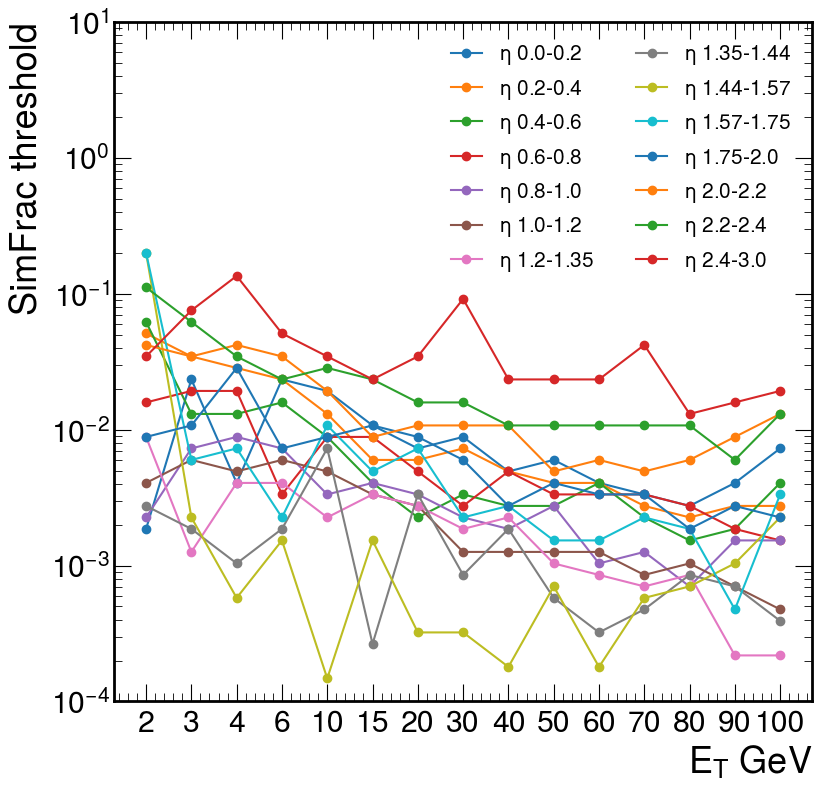

In [13]:
f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

for i in range(len(etas)-1): 
    b = a[a.eta_bin == i]
    ax.plot(b.et_bin, b.thr, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]), marker="o")

ax.legend(fontsize="xx-small", loc='upper right', ncol=2)
ax.set_ylabel("SimFrac threshold")
ax.set_xlabel("$E_T$ GeV")
ax.set_ylim(1e-4, 10)
ax.set_yscale("log")
ax.set_xticks(list(range(len(ets)-1)))
ax.set_xticklabels(["{}".format(et) for et in ets[1:]])

f.savefig(outputdir+'/Scale_all.png')

<ipython-input-14-51f5e21120f3>:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(c.T, cmap="plasma", norm=colors.LogNorm(), origin="lower", vmin=1e-4)


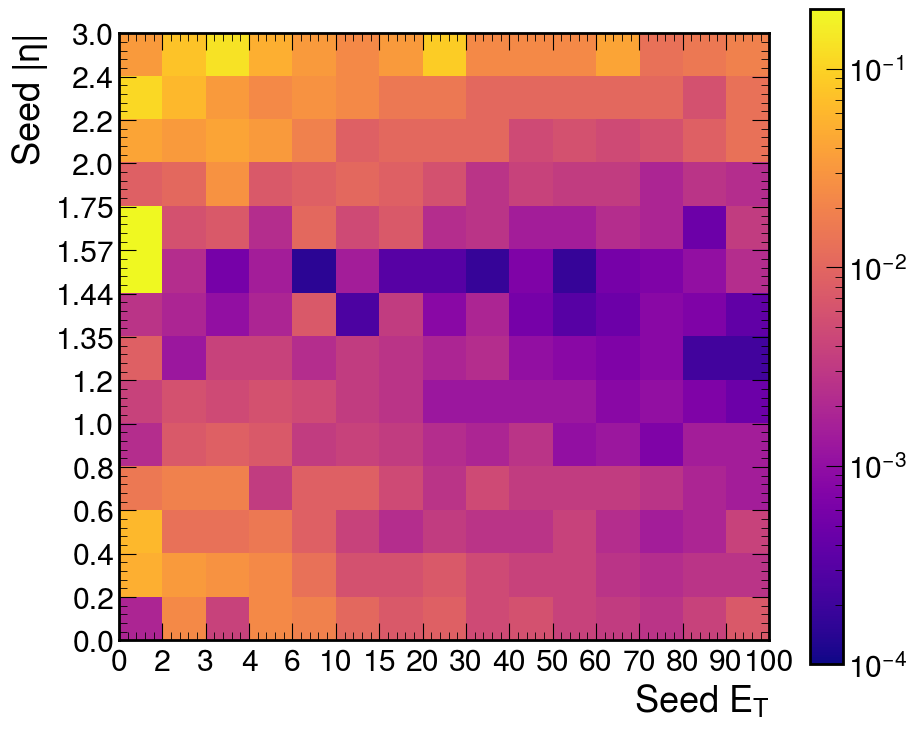

In [14]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.thr.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", norm=colors.LogNorm(), origin="lower", vmin=1e-4)
plt.colorbar()
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map.png")

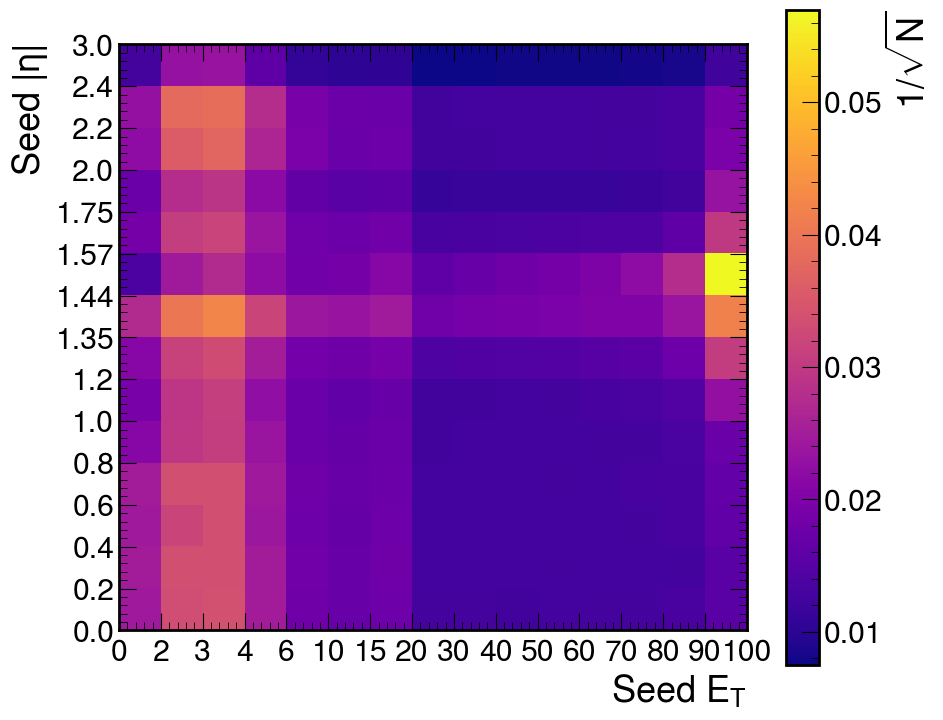

In [15]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.rel_err.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="$1 / \sqrt{N}$")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_relerr.png")

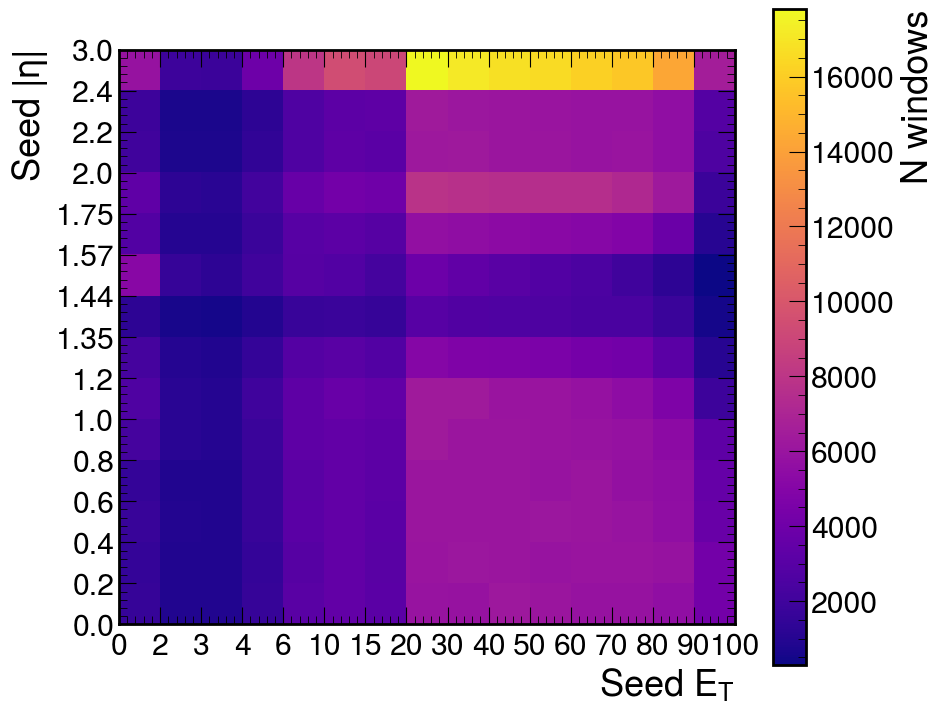

In [16]:
f = plt.figure(figsize=(10,8), dpi=100)
c = np.square((1/ a.rel_err).values).reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="N windows")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_Nwindows.png")

# Save histogram

In [17]:
import ROOT as R
from array import array

Welcome to JupyROOT 6.24/00


In [18]:
h2 = R.TH2F("h2_Minimum_simScore_seedBins", "thr", len(ets)-1, array("d", ets), len(etas)-1, array("d", etas))

In [19]:
for _, row in a.iterrows():
    h2.SetBinContent(h2.FindBin(ets[int(row.et_bin)], etas[int(row.eta_bin)]), row.thr)

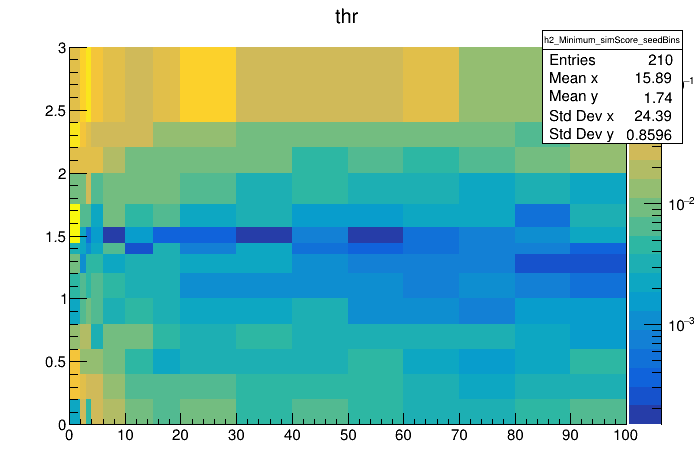

In [20]:
c = R.TCanvas()
h2.Draw("COLZ")
c.SetLogz()
c.Draw()

In [21]:
out = R.TFile("simScore_ele.root","RECREATE")
h2.Write()
out.Close()